In [1]:
import torch
import torch.nn as nn

In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

/Users/marcusdreisler/miniconda3/envs/PML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training:   1%|          | 235/23500 [00:17<45:26,  8.53it/s, epoch=1/100, loss=⠀      0.1382, lr=9.77E-04]

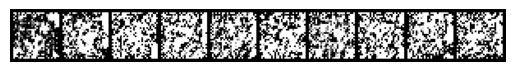

Training:   2%|▏         | 469/23500 [00:39<25:30, 15.05it/s, epoch=2/100, loss=⠀      0.0931, lr=9.54E-04]  

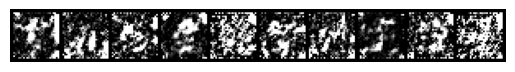

Training:   3%|▎         | 704/23500 [01:01<24:42, 15.38it/s, epoch=3/100, loss=⠀      0.0701, lr=9.32E-04]  

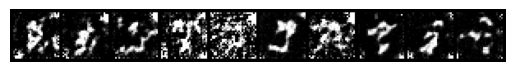

Training:   4%|▍         | 939/23500 [01:22<24:14, 15.51it/s, epoch=4/100, loss=⠀      0.0980, lr=9.10E-04]  

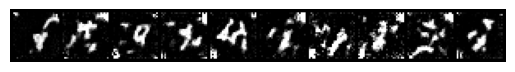

Training:   5%|▌         | 1175/23500 [01:44<22:49, 16.30it/s, epoch=5/100, loss=⠀      0.0520, lr=8.89E-04] 

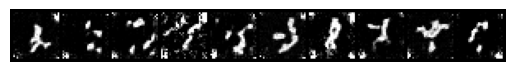

Training:   6%|▌         | 1409/23500 [02:06<23:45, 15.50it/s, epoch=6/100, loss=⠀      0.0664, lr=8.68E-04]  

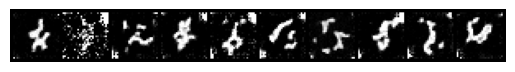

Training:   7%|▋         | 1645/23500 [02:28<22:41, 16.05it/s, epoch=7/100, loss=⠀      0.0591, lr=8.48E-04]  

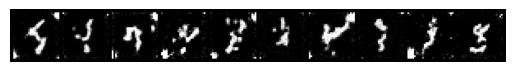

Training:   8%|▊         | 1879/23500 [02:50<24:22, 14.79it/s, epoch=8/100, loss=⠀      0.0524, lr=8.29E-04]  

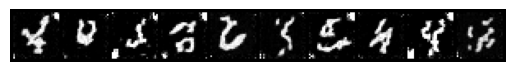

Training:   9%|▉         | 2115/23500 [03:13<22:02, 16.18it/s, epoch=9/100, loss=⠀      0.0469, lr=8.09E-04]  

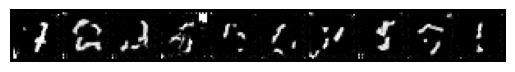

Training:  10%|▉         | 2349/23500 [03:34<22:50, 15.43it/s, epoch=10/100, loss=⠀      0.0397, lr=7.91E-04]  

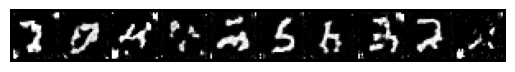

Training:  11%|█         | 2585/23500 [03:56<21:45, 16.02it/s, epoch=11/100, loss=⠀      0.0592, lr=7.72E-04]  

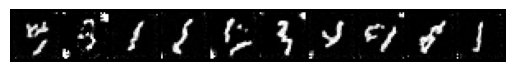

Training:  12%|█▏        | 2819/23500 [04:18<22:25, 15.37it/s, epoch=12/100, loss=⠀      0.0397, lr=7.54E-04]  

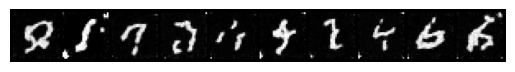

Training:  13%|█▎        | 3055/23500 [04:41<23:36, 14.43it/s, epoch=13/100, loss=⠀      0.0451, lr=7.37E-04]  

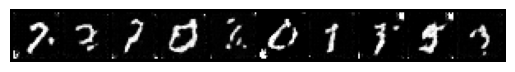

Training:  14%|█▍        | 3289/23500 [05:08<42:00,  8.02it/s, epoch=14/100, loss=⠀      0.0471, lr=7.20E-04]  

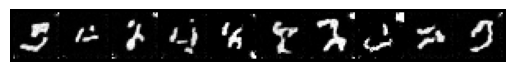

Training:  15%|█▌        | 3525/23500 [05:30<21:13, 15.68it/s, epoch=15/100, loss=⠀      0.0502, lr=7.03E-04]  

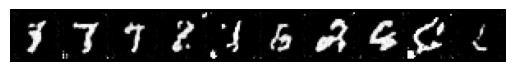

Training:  16%|█▌        | 3759/23500 [05:53<22:06, 14.88it/s, epoch=16/100, loss=⠀      0.0401, lr=6.87E-04]  

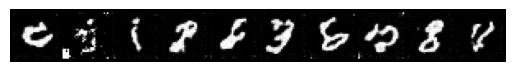

Training:  17%|█▋        | 3994/23500 [06:22<21:55, 14.83it/s, epoch=17/100, loss=⠀      0.0365, lr=6.71E-04]  

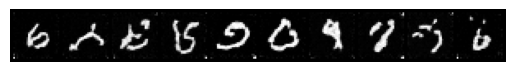

Training:  18%|█▊        | 4230/23500 [06:44<20:17, 15.83it/s, epoch=18/100, loss=⠀      0.0282, lr=6.55E-04]  

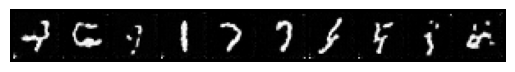

Training:  19%|█▉        | 4464/23500 [07:07<20:51, 15.21it/s, epoch=19/100, loss=⠀      0.0397, lr=6.40E-04]  

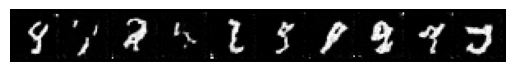

Training:  20%|██        | 4700/23500 [07:29<19:11, 16.33it/s, epoch=20/100, loss=⠀      0.0302, lr=6.25E-04]  

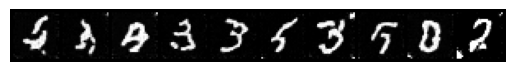

Training:  21%|██        | 4934/23500 [07:51<20:13, 15.30it/s, epoch=21/100, loss=⠀      0.0466, lr=6.10E-04]  

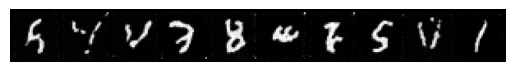

Training:  22%|██▏       | 5169/23500 [08:12<19:46, 15.45it/s, epoch=22/100, loss=⠀      0.0379, lr=5.96E-04]  

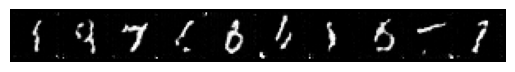

Training:  23%|██▎       | 5404/23500 [08:34<19:40, 15.33it/s, epoch=23/100, loss=⠀      0.0426, lr=5.82E-04]  

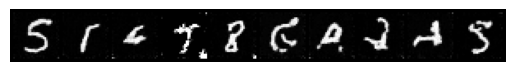

Training:  24%|██▍       | 5640/23500 [08:56<18:15, 16.30it/s, epoch=24/100, loss=⠀      0.0370, lr=5.69E-04]  

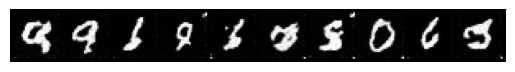

Training:  25%|██▍       | 5874/23500 [09:17<19:16, 15.25it/s, epoch=25/100, loss=⠀      0.0472, lr=5.56E-04]  

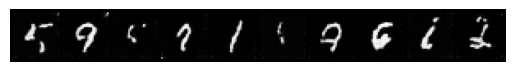

Training:  26%|██▌       | 6109/23500 [09:39<18:48, 15.40it/s, epoch=26/100, loss=⠀      0.0345, lr=5.43E-04]  

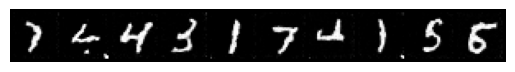

Training:  27%|██▋       | 6344/23500 [10:00<18:37, 15.35it/s, epoch=27/100, loss=⠀      0.0395, lr=5.30E-04]  

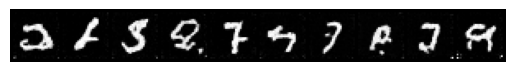

Training:  28%|██▊       | 6580/23500 [10:22<17:06, 16.48it/s, epoch=28/100, loss=⠀      0.0370, lr=5.18E-04]  

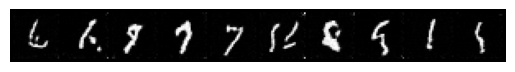

Training:  29%|██▉       | 6814/23500 [10:44<18:09, 15.31it/s, epoch=29/100, loss=⠀      0.0365, lr=5.06E-04]  

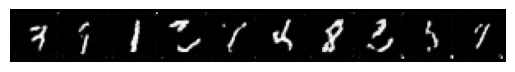

Training:  30%|██▉       | 7049/23500 [11:05<17:49, 15.38it/s, epoch=30/100, loss=⠀      0.0343, lr=4.94E-04]  

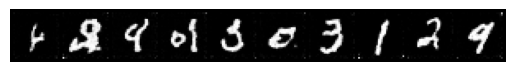

Training:  31%|███       | 7285/23500 [11:27<16:57, 15.93it/s, epoch=31/100, loss=⠀      0.0318, lr=4.83E-04]  

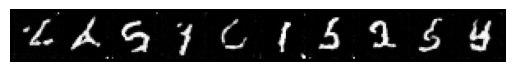

Training:  32%|███▏      | 7519/23500 [11:49<17:10, 15.51it/s, epoch=32/100, loss=⠀      0.0401, lr=4.71E-04]  

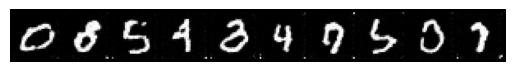

Training:  33%|███▎      | 7754/23500 [12:11<17:19, 15.14it/s, epoch=33/100, loss=⠀      0.0372, lr=4.60E-04]  

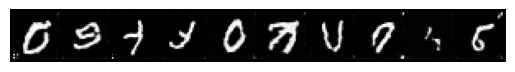

Training:  34%|███▍      | 7989/23500 [12:33<16:52, 15.31it/s, epoch=34/100, loss=⠀      0.0338, lr=4.50E-04]  

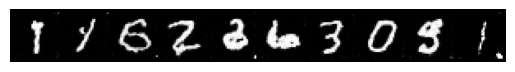

Training:  35%|███▍      | 8224/23500 [12:55<16:46, 15.18it/s, epoch=35/100, loss=⠀      0.0389, lr=4.39E-04]  

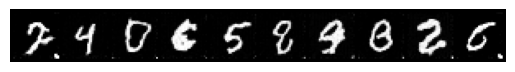

Training:  36%|███▌      | 8460/23500 [13:16<15:39, 16.00it/s, epoch=36/100, loss=⠀      0.0358, lr=4.29E-04]  

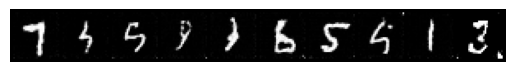

Training:  37%|███▋      | 8694/23500 [13:38<16:05, 15.33it/s, epoch=37/100, loss=⠀      0.0350, lr=4.19E-04]  

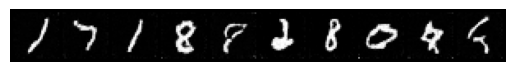

Training:  38%|███▊      | 8930/23500 [14:00<14:44, 16.48it/s, epoch=38/100, loss=⠀      0.0258, lr=4.09E-04]  

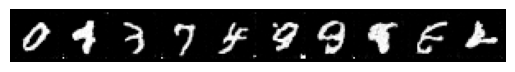

Training:  39%|███▉      | 9164/23500 [14:22<15:43, 15.20it/s, epoch=39/100, loss=⠀      0.0295, lr=4.00E-04]  

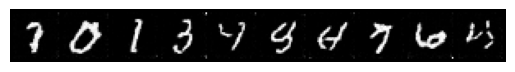

Training:  40%|███▉      | 9399/23500 [14:44<15:23, 15.26it/s, epoch=40/100, loss=⠀      0.0311, lr=3.91E-04]  

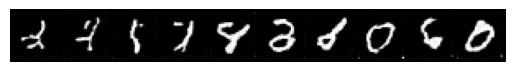

Training:  41%|████      | 9635/23500 [15:05<14:15, 16.21it/s, epoch=41/100, loss=⠀      0.0358, lr=3.82E-04]  

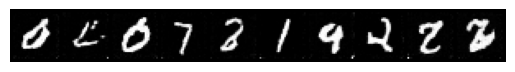

Training:  42%|████▏     | 9869/23500 [15:27<14:36, 15.55it/s, epoch=42/100, loss=⠀      0.0348, lr=3.73E-04]  

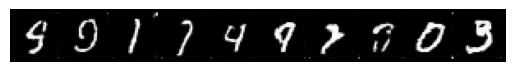

Training:  43%|████▎     | 10104/23500 [15:48<14:35, 15.30it/s, epoch=43/100, loss=⠀      0.0296, lr=3.64E-04] 

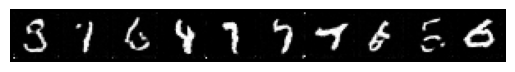

Training:  44%|████▍     | 10340/23500 [16:10<13:26, 16.31it/s, epoch=44/100, loss=⠀      0.0317, lr=3.56E-04]  

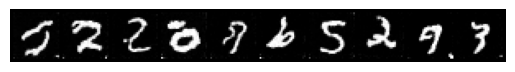

Training:  45%|████▍     | 10574/23500 [16:32<14:05, 15.28it/s, epoch=45/100, loss=⠀      0.0402, lr=3.47E-04]  

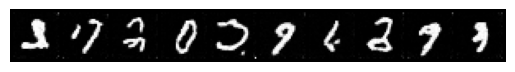

Training:  46%|████▌     | 10809/23500 [16:53<13:49, 15.29it/s, epoch=46/100, loss=⠀      0.0311, lr=3.39E-04]  

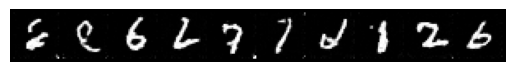

Training:  47%|████▋     | 11044/23500 [17:15<13:58, 14.86it/s, epoch=47/100, loss=⠀      0.0360, lr=3.31E-04]  

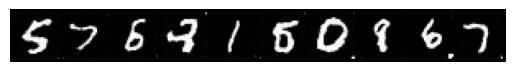

Training:  48%|████▊     | 11279/23500 [17:36<13:15, 15.36it/s, epoch=48/100, loss=⠀      0.0337, lr=3.24E-04]  

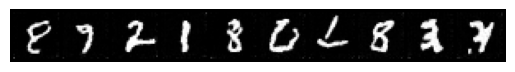

Training:  49%|████▉     | 11514/23500 [17:58<13:05, 15.26it/s, epoch=49/100, loss=⠀      0.0355, lr=3.16E-04]  

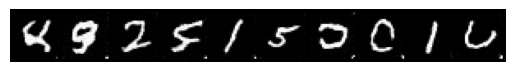

Training:  50%|████▉     | 11749/23500 [18:20<12:39, 15.48it/s, epoch=50/100, loss=⠀      0.0368, lr=3.09E-04]  

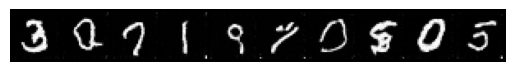

Training:  51%|█████     | 11985/23500 [18:42<11:50, 16.20it/s, epoch=51/100, loss=⠀      0.0296, lr=3.02E-04]  

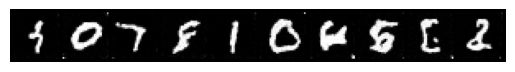

Training:  52%|█████▏    | 12219/23500 [19:03<12:16, 15.32it/s, epoch=52/100, loss=⠀      0.0348, lr=2.95E-04]  

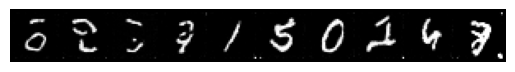

Training:  53%|█████▎    | 12454/23500 [19:25<12:00, 15.33it/s, epoch=53/100, loss=⠀      0.0369, lr=2.88E-04]  

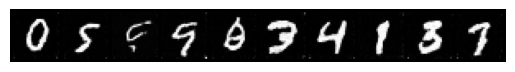

Training:  54%|█████▍    | 12690/23500 [19:47<10:59, 16.38it/s, epoch=54/100, loss=⠀      0.0350, lr=2.81E-04]  

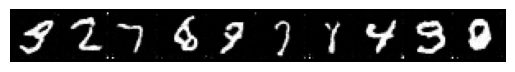

Training:  55%|█████▍    | 12924/23500 [20:09<11:31, 15.28it/s, epoch=55/100, loss=⠀      0.0392, lr=2.75E-04]  

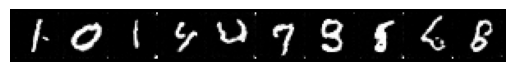

Training:  56%|█████▌    | 13159/23500 [20:30<11:10, 15.43it/s, epoch=56/100, loss=⠀      0.0327, lr=2.68E-04]  

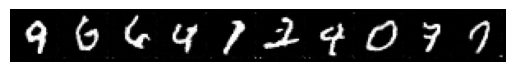

Training:  57%|█████▋    | 13394/23500 [20:52<11:02, 15.25it/s, epoch=57/100, loss=⠀      0.0322, lr=2.62E-04]  

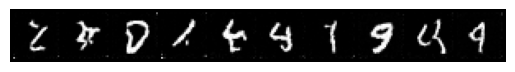

Training:  58%|█████▊    | 13629/23500 [21:14<10:40, 15.41it/s, epoch=58/100, loss=⠀      0.0268, lr=2.56E-04]  

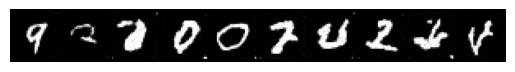

Training:  59%|█████▉    | 13864/23500 [21:35<10:39, 15.08it/s, epoch=59/100, loss=⠀      0.0311, lr=2.50E-04]  

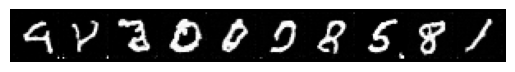

Training:  60%|██████    | 14100/23500 [21:57<09:31, 16.44it/s, epoch=60/100, loss=⠀      0.0334, lr=2.44E-04]  

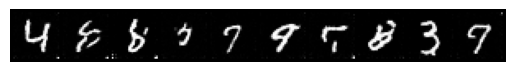

Training:  61%|██████    | 14334/23500 [22:18<09:56, 15.37it/s, epoch=61/100, loss=⠀      0.0231, lr=2.38E-04]  

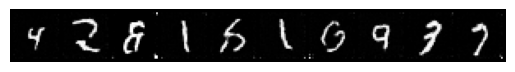

Training:  62%|██████▏   | 14570/23500 [22:40<09:21, 15.90it/s, epoch=62/100, loss=⠀      0.0300, lr=2.33E-04]  

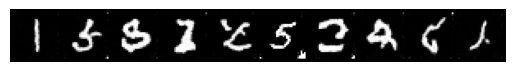

Training:  63%|██████▎   | 14804/23500 [23:02<09:28, 15.29it/s, epoch=63/100, loss=⠀      0.0314, lr=2.28E-04]  

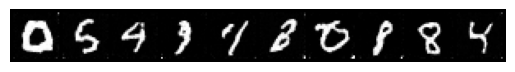

Training:  64%|██████▍   | 15040/23500 [23:24<08:50, 15.96it/s, epoch=64/100, loss=⠀      0.0384, lr=2.22E-04]  

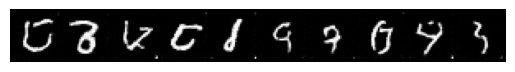

Training:  65%|██████▍   | 15274/23500 [23:46<09:11, 14.93it/s, epoch=65/100, loss=⠀      0.0358, lr=2.17E-04]  

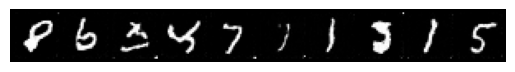

Training:  66%|██████▌   | 15509/23500 [24:08<08:44, 15.25it/s, epoch=66/100, loss=⠀      0.0347, lr=2.12E-04]  

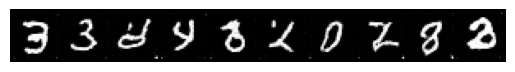

Training:  67%|██████▋   | 15744/23500 [24:30<08:26, 15.33it/s, epoch=67/100, loss=⠀      0.0292, lr=2.07E-04]  

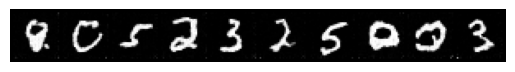

Training:  68%|██████▊   | 15980/23500 [24:52<07:43, 16.23it/s, epoch=68/100, loss=⠀      0.0283, lr=2.02E-04]  

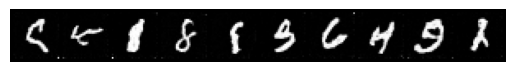

Training:  69%|██████▉   | 16214/23500 [25:13<07:56, 15.29it/s, epoch=69/100, loss=⠀      0.0305, lr=1.98E-04]  

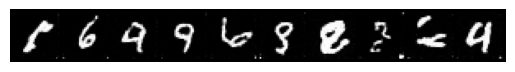

Training:  70%|██████▉   | 16449/23500 [25:35<07:40, 15.30it/s, epoch=70/100, loss=⠀      0.0261, lr=1.93E-04]  

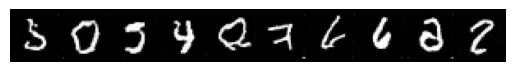

Training:  71%|███████   | 16685/23500 [25:57<06:57, 16.31it/s, epoch=71/100, loss=⠀      0.0284, lr=1.89E-04]  

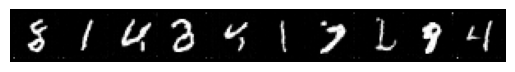

Training:  72%|███████▏  | 16919/23500 [26:19<07:07, 15.38it/s, epoch=72/100, loss=⠀      0.0244, lr=1.84E-04]  

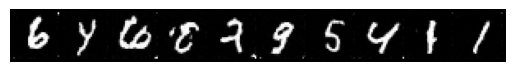

Training:  73%|███████▎  | 17154/23500 [26:40<07:00, 15.08it/s, epoch=73/100, loss=⠀      0.0339, lr=1.80E-04]  

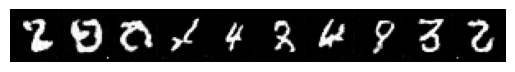

Training:  74%|███████▍  | 17389/23500 [27:02<06:36, 15.40it/s, epoch=74/100, loss=⠀      0.0340, lr=1.76E-04]  

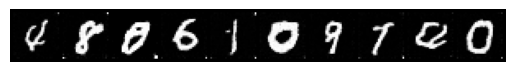

Training:  75%|███████▌  | 17625/23500 [27:24<05:59, 16.35it/s, epoch=75/100, loss=⠀      0.0348, lr=1.72E-04]  

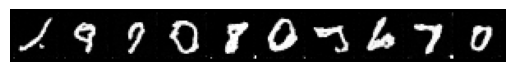

Training:  76%|███████▌  | 17859/23500 [27:46<06:04, 15.47it/s, epoch=76/100, loss=⠀      0.0303, lr=1.68E-04]  

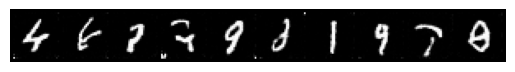

Training:  77%|███████▋  | 18095/23500 [28:08<05:37, 16.02it/s, epoch=77/100, loss=⠀      0.0366, lr=1.64E-04]  

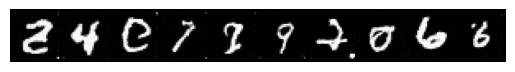

Training:  78%|███████▊  | 18329/23500 [28:30<05:34, 15.45it/s, epoch=78/100, loss=⠀      0.0285, lr=1.60E-04]  

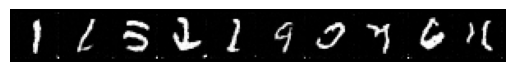

Training:  79%|███████▉  | 18565/23500 [28:52<05:00, 16.45it/s, epoch=79/100, loss=⠀      0.0344, lr=1.56E-04]  

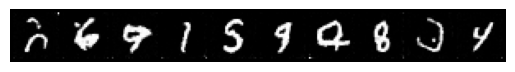

Training:  80%|███████▉  | 18799/23500 [29:13<05:02, 15.52it/s, epoch=80/100, loss=⠀      0.0230, lr=1.53E-04]  

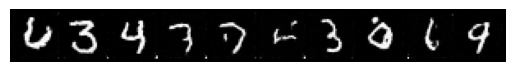

Training:  81%|████████  | 19034/23500 [29:35<04:52, 15.28it/s, epoch=81/100, loss=⠀      0.0267, lr=1.49E-04]  

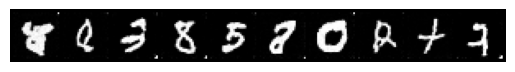

Training:  82%|████████▏ | 19269/23500 [29:56<04:33, 15.48it/s, epoch=82/100, loss=⠀      0.0310, lr=1.46E-04]  

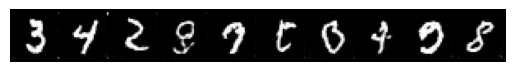

Training:  83%|████████▎ | 19504/23500 [30:18<04:21, 15.29it/s, epoch=83/100, loss=⠀      0.0298, lr=1.42E-04]  

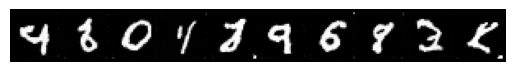

Training:  84%|████████▍ | 19740/23500 [30:39<03:49, 16.35it/s, epoch=84/100, loss=⠀      0.0278, lr=1.39E-04]

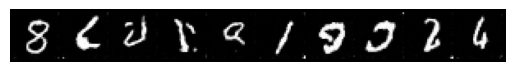

Training:  85%|████████▍ | 19974/23500 [31:01<03:50, 15.29it/s, epoch=85/100, loss=⠀      0.0287, lr=1.36E-04]  

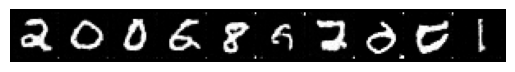

Training:  86%|████████▌ | 20209/23500 [31:23<03:33, 15.44it/s, epoch=86/100, loss=⠀      0.0283, lr=1.33E-04]

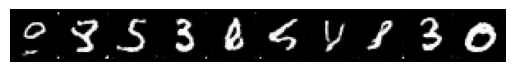

Training:  87%|████████▋ | 20445/23500 [31:44<03:09, 16.10it/s, epoch=87/100, loss=⠀      0.0262, lr=1.29E-04]

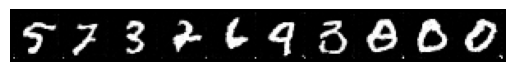

Training:  88%|████████▊ | 20679/23500 [32:06<03:02, 15.44it/s, epoch=88/100, loss=⠀      0.0288, lr=1.26E-04]

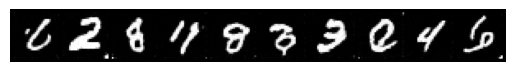

Training:  89%|████████▉ | 20914/23500 [32:28<02:49, 15.28it/s, epoch=89/100, loss=⠀      0.0329, lr=1.23E-04]

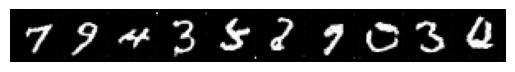

Training:  90%|█████████ | 21150/23500 [32:50<02:24, 16.28it/s, epoch=90/100, loss=⠀      0.0307, lr=1.21E-04]

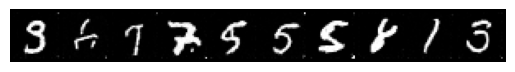

Training:  91%|█████████ | 21384/23500 [33:11<02:18, 15.23it/s, epoch=91/100, loss=⠀      0.0352, lr=1.18E-04]

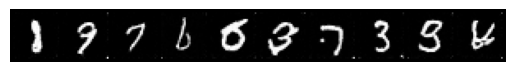

Training:  92%|█████████▏| 21619/23500 [33:33<02:02, 15.39it/s, epoch=92/100, loss=⠀      0.0301, lr=1.15E-04]

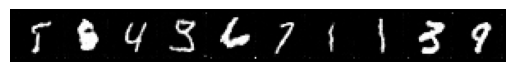

Training:  93%|█████████▎| 21855/23500 [33:55<01:41, 16.24it/s, epoch=93/100, loss=⠀      0.0312, lr=1.12E-04]

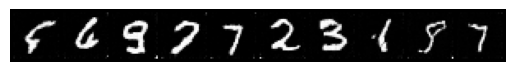

Training:  94%|█████████▍| 22089/23500 [34:17<01:31, 15.45it/s, epoch=94/100, loss=⠀      0.0260, lr=1.10E-04]

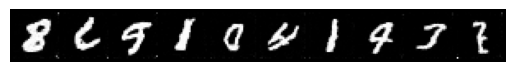

Training:  95%|█████████▌| 22325/23500 [34:38<01:11, 16.41it/s, epoch=95/100, loss=⠀      0.0247, lr=1.07E-04]

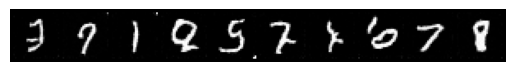

Training:  96%|█████████▌| 22559/23500 [35:00<01:00, 15.47it/s, epoch=96/100, loss=⠀      0.0253, lr=1.05E-04]

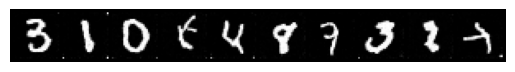

Training:  97%|█████████▋| 22794/23500 [35:21<00:46, 15.25it/s, epoch=97/100, loss=⠀      0.0308, lr=1.02E-04]

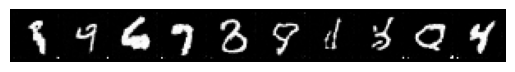

Training:  98%|█████████▊| 23029/23500 [35:43<00:30, 15.42it/s, epoch=98/100, loss=⠀      0.0252, lr=9.99E-05]

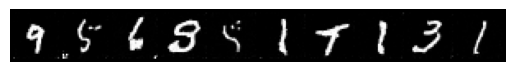

Training:  99%|█████████▉| 23264/23500 [36:05<00:15, 15.21it/s, epoch=99/100, loss=⠀      0.0279, lr=9.76E-05]

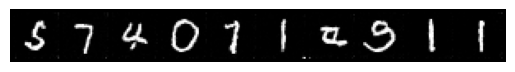

Training: 100%|█████████▉| 23499/23500 [36:26<00:00, 15.41it/s, epoch=100/100, loss=⠀      0.0338, lr=9.54E-05]

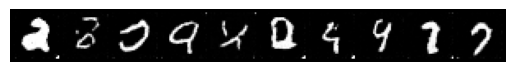

Training: 100%|██████████| 23500/23500 [36:33<00:00, 10.72it/s, epoch=100/100, loss=⠀      0.0338, lr=9.54E-05]


In [4]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
from diffusion_utils import gaussian_nll, pred_xstart_from_eps
from functions import normal_kl, discretized_gaussian_loglik, flat_mean

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2, x0_parameterization=False, use_low_discrepancy_sampler=False):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        self.x0_parameterization = x0_parameterization
        self.use_low_discrepancy_sampler = use_low_discrepancy_sampler

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """
        
        #equation 11 in Ho et al, 2020
        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 

        #std sounds more like an art: "Experimentally, both σt2 = βt and σ2 = β ̃ = 1−α ̄t−1 β had similar results.""
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    def reverse_diffusion_x0_parameterization(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int or torch.tensor
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        # Network now predicts the initial image x0
        estimated_x0 = self.network(xt, t)

        alpha = self.alpha[t]
        alpha_bar = self.alpha_bar[t]
        alpha_bar_prev = self.alpha_bar[t-1]
        beta = self.beta[t]

        # Equation 6+7 in Ho et al, 2020

        beta_tilde = ((1-alpha_bar_prev)/(1-alpha_bar))*beta
        std = torch.sqrt(beta_tilde)

        coeff1 = torch.sqrt(alpha_bar_prev)/(1-alpha_bar)*beta
        coeff2 = torch.sqrt(alpha)*(1-alpha_bar_prev)/(1-alpha_bar)

        mean = coeff1*estimated_x0 + coeff2*xt
        
        return mean + std * epsilon

    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)   
            if self.x0_parameterization:
                xt = self.reverse_diffusion_x0_parameterization(xt, t, noise)
            else:         
                xt = self.reverse_diffusion(xt, t, noise)

        return xt

    def low_discrepancy_t_sampler(self, batch_size, device):
        k = batch_size
        u0 = np.random.uniform(0, 1)

        # ti = mod(u0 + i/k, 1) for i=0,1,...,k-1
        ti = torch.fmod(torch.arange(0, k, device=device)/k + u0, 1)
        return (ti*self.T).long().unsqueeze(1)

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        if self.use_low_discrepancy_sampler:
            t = self.low_discrepancy_t_sampler(x0.shape[0], x0.device)
        else:
            # Sample time step t
            t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))


    def elbo_simple_x0_reparameterization(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020), modified. Network tries to predict the noise, but the loss is taken in 

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        estimated_x0 = self.network(xt, t)
        
        return -nn.MSELoss(reduction='mean')(x0, estimated_x0)

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        if self.x0_parameterization:
            return -self.elbo_simple_x0_reparameterization(x0).mean()
        else:
            return -self.elbo_simple(x0).mean()

    
    # === log likelihood ===
    # bpd: bits per dimension

    @staticmethod
    def _extract(
            arr, t, x,
            dtype=torch.float32, device=torch.device("cpu"), ndim=4):
        if x is not None:
            dtype = x.dtype
            device = x.device
            ndim = x.ndim
        out = torch.as_tensor(arr, dtype=dtype, device=device).gather(0, t)
        return out.reshape((-1, ) + (1, ) * (ndim - 1))

    def q_mean_var(self, x_0, t):
        mean = self._extract(self.sqrt_alphas_bar, t, x_0) * x_0
        var = self._extract(1. - self.alphas_bar, t, x_0)
        logvar = self._extract(torch.log(1 - self.alphas_bar), t, x_0)
        return mean, var, logvar

    def q_sample(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        coef1 = self._extract(self.sqrt_alphas_bar, t, x_0)
        coef2 = self._extract(self.sqrt_one_minus_alphas_bar, t, x_0)
        return coef1 * x_0 + coef2 * noise

    def q_posterior_mean_var(self, x_0, x_t, t):
        posterior_mean_coef1 = self._extract(self.posterior_mean_coef1, t, x_0)
        posterior_mean_coef2 = self._extract(self.posterior_mean_coef2, t, x_0)
        posterior_mean = posterior_mean_coef1 * x_0 + posterior_mean_coef2 * x_t
        posterior_var = self._extract(self.posterior_var, t, x_0)
        posterior_logvar = self._extract(self.posterior_logvar_clipped, t, x_0)
        return posterior_mean, posterior_var, posterior_logvar

    def _loss_term_bpd(self, denoise_fn, x_0, x_t, t, clip_denoised, return_pred):
        # calculate L_t
        # t = 0: negative log likelihood of decoder, -\log p(x_0 | x_1)
        # t > 0: variational lower bound loss term, KL term
        true_mean, _, true_logvar = self.q_posterior_mean_var(x_0=x_0, x_t=x_t, t=t)
        model_mean, _, model_logvar, pred_x_0 = self.p_mean_var(
            denoise_fn, x_t=x_t, t=t, clip_denoised=clip_denoised, return_pred=True)
        kl = normal_kl(true_mean, true_logvar, model_mean, model_logvar)
        kl = flat_mean(kl) / math.log(2.)  # natural base to base 2
        decoder_nll = discretized_gaussian_loglik(x_0, model_mean, log_scale=0.5 * model_logvar).neg()
        decoder_nll = flat_mean(decoder_nll) / math.log(2.)
        output = torch.where(t.to(kl.device) > 0, kl, decoder_nll)
        return (output, pred_x_0) if return_pred else output

    def train_losses(self, denoise_fn, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        x_t = self.q_sample(x_0, t, noise=noise)

        # calculate the loss
        # kl: weighted
        # mse: unweighted
        if self.loss_type == "kl":
            losses = self._loss_term_bpd(
                denoise_fn, x_0=x_0, x_t=x_t, t=t, clip_denoised=False, return_pred=False)
        elif self.loss_type == "mse":
            assert self.model_var_type != "learned"
            if self.model_mean_type == "mean":
                target = self.q_posterior_mean_var(x_0=x_0, x_t=x_t, t=t)[0]
            elif self.model_mean_type == "x_0":
                target = x_0
            elif self.model_mean_type == "eps":
                target = noise
            else:
                raise NotImplementedError(self.model_mean_type)
            model_out = denoise_fn(x_t, t)
            losses = flat_mean((target - model_out).pow(2))
        else:
            raise NotImplementedError(self.loss_type)

        return losses

    def _prior_bpd(self, x_0):
        B, T = len(x_0), self.timesteps
        T_mean, _, T_logvar = self.q_mean_var(
            x_0=x_0, t=(T - 1) * torch.ones((B, ), dtype=torch.int64))
        kl_prior = normal_kl(T_mean, T_logvar, mean2=0., logvar2=0.)
        return flat_mean(kl_prior) / math.log(2.)

    def calc_all_bpd(self, denoise_fn, x_0, clip_denoised=True):
        B, T = x_0.shape, self.T
        t = torch.empty([B, ], dtype=torch.int64)
        losses = torch.zeros([B, T], dtype=torch.float32)
        mses = torch.zeros([B, T], dtype=torch.float32)

        for ti in range(T - 1, -1, -1):
            t.fill_(ti)
            x_t = self.q_sample(x_0, t=t)
            loss, pred_x_0 = self._loss_term_bpd(
                denoise_fn, x_0, x_t=x_t, t=t, clip_denoised=clip_denoised, return_pred=True)
            losses[:, ti] = loss
            mses[:, ti] = flat_mean((pred_x_0 - x_0).pow(2))

        prior_bpd = self._prior_bpd(x_0)
        total_bpd = torch.sum(losses, dim=1) + prior_bpd
        return total_bpd, losses, prior_bpd, mses



def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)
        
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"model_discrete_ddpm_{epoch}.pt")


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T, x0_parameterization=False, use_low_discrepancy_sampler=False).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()   

# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)
